# Visualize Experiment Results - Downstream Performance

This notebook should answer the questions: *Does imputation lead to better downstream performances?*

## Notebook Structure 

* Application Scenario 2 - Downstream Performance  
   * Categorical  Columns (Classification)
   * Numerical Columns (Regression)
   * Hetegrogenous Columns (Classification and Regression Combined)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns

from pathlib import Path
from data_imputation_paper.experiment import read_experiment, read_csv_files

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Settings

In [2]:
sns.set(style="whitegrid")
sns.set_context('paper', font_scale=1.5)
mpl.rcParams['lines.linewidth'] = '2'

In [3]:
EXPERIMENT_PATH = Path("../data/experiments/cluster4/fully_observed/")
FIGURES_PATH = Path("../reports/figures/fully_observed/")

CLF_METRIC = "F1_macro"
REG_METRIC = "RMSE"

DOWNSTREAM_RESULT_TYPE = "downstream_performance_mean"

In [4]:
Path(FIGURES_PATH/DOWNSTREAM_RESULT_TYPE).mkdir(parents=True, exist_ok=True)

## Import the data

In [5]:
%%time

results = read_csv_files(read_experiment(EXPERIMENT_PATH), read_details=False)
assert len(results["strategy"].unique()) == 1
results.drop([], axis=1, inplace=True)
results.head()

CPU times: user 1min 9s, sys: 1.71 s, total: 1min 11s
Wall time: 1min 11s


,experiment,imputer,task,missing_type,missing_fraction,strategy,column,result_type,metric,train,test,baseline,corrupted,imputed
0,fully_observed,AutoKerasImputer,40922,MCAR,0.01,single_all,gyro_y,impute_performance_std,MAE,0.490070,0.564987,NaN,NaN,NaN
1,fully_observed,AutoKerasImputer,40922,MCAR,0.01,single_all,gyro_y,impute_performance_std,MSE,9.137480,10.071950,NaN,NaN,NaN
2,fully_observed,AutoKerasImputer,40922,MCAR,0.01,single_all,gyro_y,impute_performance_std,RMSE,0.612642,0.631353,NaN,NaN,NaN
3,fully_observed,AutoKerasImputer,40922,MCAR,0.30,single_all,gyro_y,impute_performance_std,MAE,0.125774,0.180896,NaN,NaN,NaN
4,fully_observed,AutoKerasImputer,40922,MCAR,0.30,single_all,gyro_y,impute_performance_std,MSE,2.105718,0.627795,NaN,NaN,NaN


In [6]:
downstream_results = results[
    (results["result_type"] == DOWNSTREAM_RESULT_TYPE) & 
    (results["metric"].isin([CLF_METRIC, REG_METRIC]))
]
assert len(results["strategy"].unique()) == 1
downstream_results.drop(["experiment", "strategy", "train",  "test"], axis=1, inplace=True)
downstream_results = downstream_results.rename(
    {
        "imputer": "Imputer",
        "task": "Task",
        "missing_type": "Missing Type",
        "missing_fraction": "Missing Fraction",
        "column": "Column",
        "baseline": "Baseline",
        "corrupted": "Corrupted", 	
        "imputed": "Imputed"
    },
    axis = 1
)
downstream_results.head()

,Imputer,Task,Missing Type,Missing Fraction,Column,result_type,metric,Baseline,Corrupted,Imputed
43840,AutoKerasImputer,40922,MCAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.735632,0.735387,0.735385
43843,AutoKerasImputer,40922,MCAR,0.30,gyro_y,downstream_performance_mean,F1_macro,0.735632,0.725172,0.725815
43846,AutoKerasImputer,40922,MCAR,0.50,gyro_y,downstream_performance_mean,F1_macro,0.735632,0.718076,0.719680
43849,AutoKerasImputer,40922,MCAR,0.10,gyro_y,downstream_performance_mean,F1_macro,0.735632,0.731650,0.731888
43852,AutoKerasImputer,40922,MNAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.735632,0.735432,0.735450


## Compute Downstream Performance relative to Baseline

In [7]:
clf_row_idx = downstream_results["metric"] == CLF_METRIC
reg_row_idx = downstream_results["metric"] == REG_METRIC

In [8]:
downstream_results["Corrupted Reduction"] = 0
downstream_results["Imputed Reduction"] = 0

# F1 higher is better
downstream_results.loc[clf_row_idx, "Corrupted Reduction"] = downstream_results["Corrupted"] / downstream_results["Baseline"] - 1
downstream_results.loc[clf_row_idx, "Imputed Reduction"] = downstream_results["Imputed"] / downstream_results["Baseline"]  - 1

# RMSE lower is better
downstream_results.loc[reg_row_idx, "Corrupted Reduction"] = 1 - downstream_results["Corrupted"] / downstream_results["Baseline"]
downstream_results.loc[reg_row_idx, "Imputed Reduction"] = 1 - downstream_results["Imputed"] / downstream_results["Baseline"]

downstream_results.describe()

,Missing Fraction,Baseline,Corrupted,Imputed,Corrupted Reduction,Imputed Reduction
count,4871.000000,4871.000000,4871.000000,4871.000000,4871.000000,4871.000000
mean,0.226237,630.202541,636.313290,635.267946,-0.016211,-0.015577
std,0.189075,4618.468052,4645.612172,4645.389114,0.038386,0.038677
min,0.010000,0.001418,0.001418,0.001418,-0.825983,-1.006366
25%,0.010000,0.488484,0.490119,0.490807,-0.017812,-0.017414
50%,0.100000,0.743399,0.742166,0.742285,-0.004543,-0.004398
75%,0.300000,0.966650,0.949745,0.950783,-0.000471,-0.000438
max,0.500000,41367.191450,42598.411253,42597.607852,0.077121,0.077121


In [9]:
downstream_results["Improvement"] = (downstream_results["Imputed"] - downstream_results["Corrupted"]) / downstream_results["Baseline"]

In [10]:
downstream_results

,Imputer,Task,Missing Type,Missing Fraction,Column,result_type,metric,Baseline,Corrupted,Imputed,Corrupted Reduction,Imputed Reduction,Improvement
43840,AutoKerasImputer,40922,MCAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.735632,0.735387,0.735385,-0.000333,-0.000335,-0.000003
43843,AutoKerasImputer,40922,MCAR,0.30,gyro_y,downstream_performance_mean,F1_macro,0.735632,0.725172,0.725815,-0.014219,-0.013345,0.000874
43846,AutoKerasImputer,40922,MCAR,0.50,gyro_y,downstream_performance_mean,F1_macro,0.735632,0.718076,0.719680,-0.023865,-0.021684,0.002181
43849,AutoKerasImputer,40922,MCAR,0.10,gyro_y,downstream_performance_mean,F1_macro,0.735632,0.731650,0.731888,-0.005414,-0.005089,0.000325
43852,AutoKerasImputer,40922,MNAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.735632,0.735432,0.735450,-0.000272,-0.000248,0.000025
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58438,GAINImputer,1220,MCAR,0.10,keyword_id,downstream_performance_mean,F1_macro,0.476541,0.475419,0.475419,-0.002355,-0.002355,0.000000
58441,GAINImputer,1220,MNAR,0.01,keyword_id,downstream_performance_mean,F1_macro,0.476541,0.476541,0.476541,0.000000,0.000000,0.000000
58444,GAINImputer,1220,MNAR,0.30,keyword_id,downstream_performance_mean,F1_macro,0.476541,0.476006,0.476006,-0.001122,-0.001122,0.000000
58447,GAINImputer,1220,MNAR,0.50,keyword_id,downstream_performance_mean,F1_macro,0.476541,0.476433,0.476433,-0.000228,-0.000228,0.000000


## Application Scenario 2 - Downstream Performance

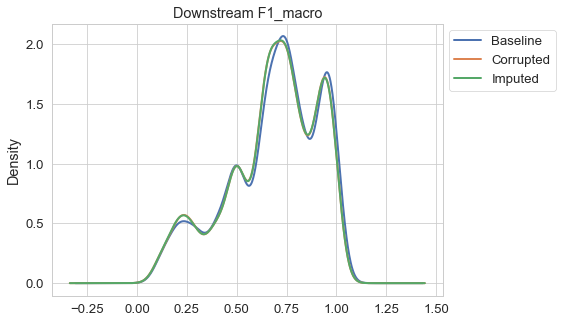

In [11]:
downstream_results.loc[clf_row_idx,["Baseline", "Corrupted", "Imputed"]].plot(kind="kde", title=f"Downstream {CLF_METRIC}", figsize=(7,5))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

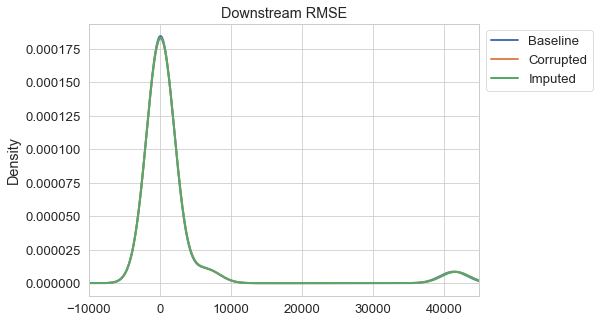

In [12]:
downstream_results.loc[reg_row_idx,["Baseline", "Corrupted", "Imputed"]].plot(kind="kde", title=f"Downstream {REG_METRIC}", figsize=(7,5), xlim=(-10000, 45000))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

### Categorical  Columns (Classification)

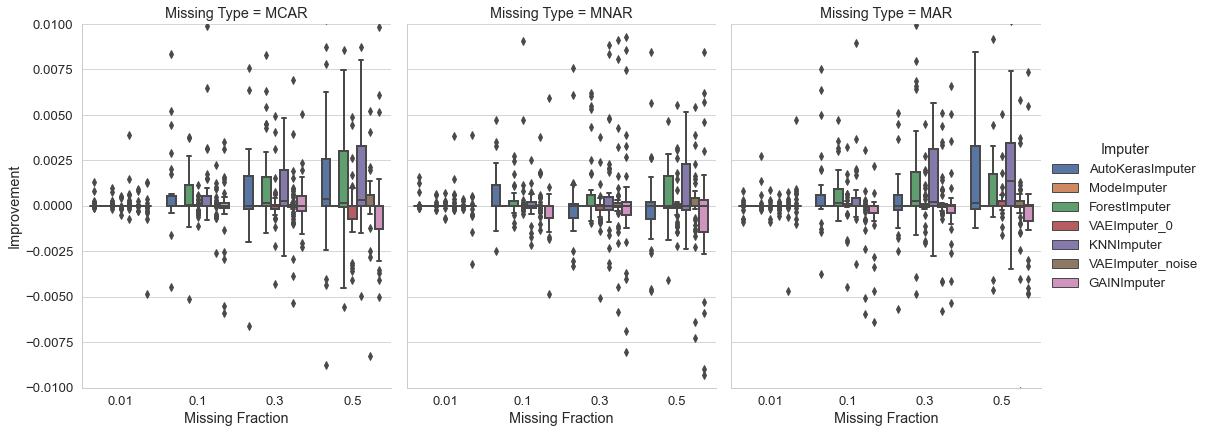

In [13]:
plot_data = downstream_results[clf_row_idx]

ax = sns.catplot(
    x="Missing Fraction", 
    y="Improvement",
    hue="Imputer", 
    #style="Imputer",
    col="Missing Type",
    data=plot_data, 
    kind="box",
    height=6, 
    aspect=.8,
)
ax.set(ylim=(-0.01, 0.01))

### Numerical Columns (Regression)

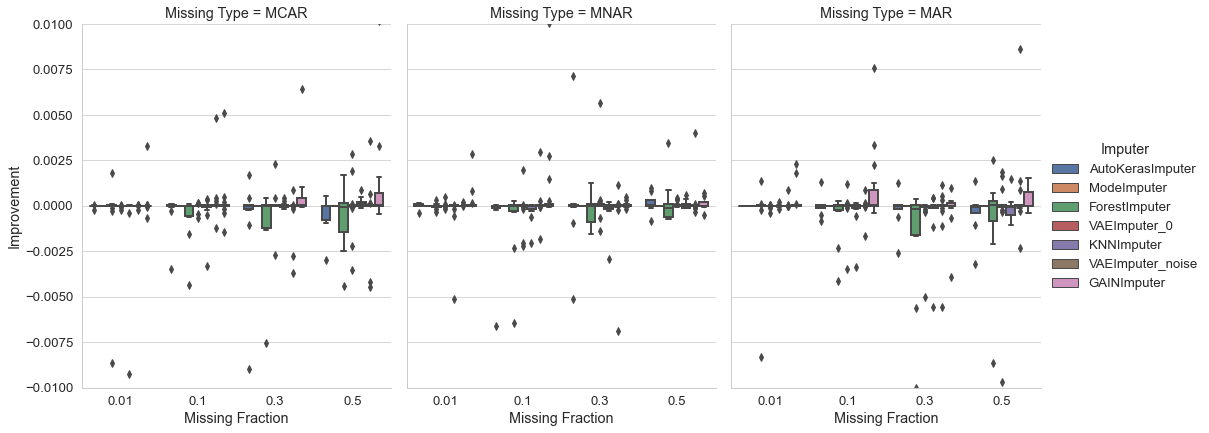

In [14]:
plot_data = downstream_results[reg_row_idx]

ax = sns.catplot(
    x="Missing Fraction", 
    y="Improvement",
    hue="Imputer", 
    #style="Imputer",
    col="Missing Type",
    data=plot_data, 
    kind="box",
    height=6, 
    aspect=.8,
)
ax.set(ylim=(-0.01, 0.01))

### Heterogenous Columns (Classification and Regression Combined)

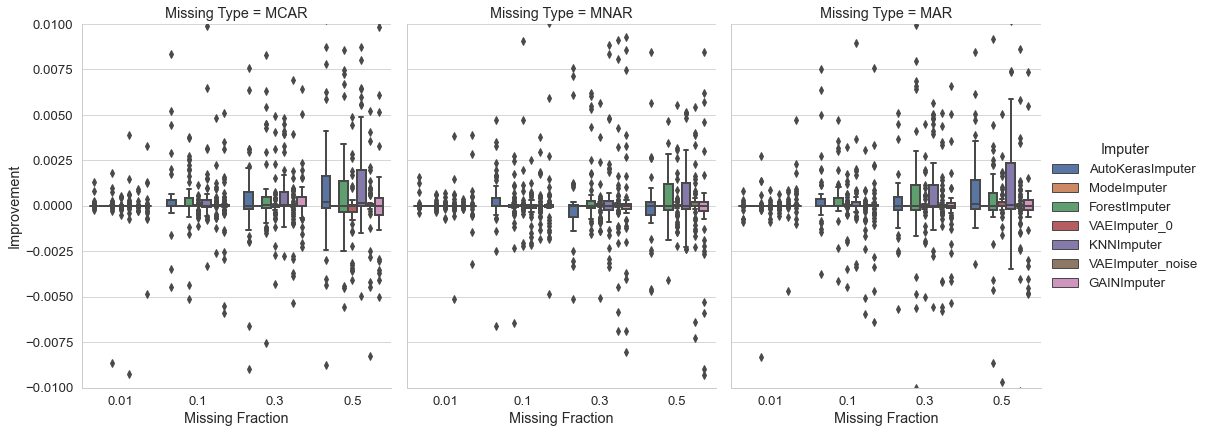

In [15]:
plot_data = downstream_results

ax = sns.catplot(
    x="Missing Fraction", 
    y="Improvement",
    hue="Imputer", 
    #style="Imputer",
    col="Missing Type",
    data=plot_data, 
    kind="box",
    height=6, 
    aspect=.8,
)
ax.set(ylim=(-0.01, 0.01))